In [40]:
import numpy as np
import pandas as pd
import json
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from joblib import parallel_backend
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)
SEED = 42

In [41]:
# Load data
train_df = pd.read_csv("Tables/bnpl_train.csv")
test_df = pd.read_csv("Tables/bnpl_test.csv")
val_df = pd.read_csv("Tables/bnpl_val.csv")
target_col = "default_flag"

In [42]:
#Quick data checks
print(train_df.shape, test_df.shape, val_df.shape)
print(train_df.head(),test_df.head(), val_df.head())
print("Train nulls in target:", train_df["default_flag"].isna().sum())
print("Train class distribution:\n", train_df["default_flag"].value_counts(normalize=True))

(595, 14) (199, 14) (199, 14)
   external_repayment_loans  credit_card_interest_incidence  default_flag  \
0                         1                               0             0   
1                         0                               0             0   
2                         0                               0             0   
3                         0                               1             0   
4                         1                               1             0   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0             -0.730258               -1.246089                 -1.746734   
1              1.319109                0.529472                 -0.222965   
2              0.408279                1.239697                  0.805578   
3             -1.641088                1.594809                 -0.184871   
4              0.408279                0.529472                 -1.556263   

   payment_delinquency_count  impulsive_buyi

In [43]:
# Split features and target for data
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
print("X_train shape:", X_train.shape, X_train.head())
print("y_train shape:", y_train.shape, y_train.head())
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]
print("X_test shape:", X_test.shape, X_test.head())
print("y_test shape:", y_test.shape, y_test.head())
X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]
print("X_val shape:", X_val.shape, X_val.head())
print("y_val shape:", y_val.shape, y_val.head())

X_train shape: (595, 13)    external_repayment_loans  credit_card_interest_incidence  \
0                         1                               0   
1                         0                               0   
2                         0                               0   
3                         0                               1   
4                         1                               1   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0             -0.730258               -1.246089                 -1.746734   
1              1.319109                0.529472                 -0.222965   
2              0.408279                1.239697                  0.805578   
3             -1.641088                1.594809                 -0.184871   
4              0.408279                0.529472                 -1.556263   

   payment_delinquency_count  impulsive_buying_score  \
0                  -1.500097               -0.528311   
1                  -1

In [44]:
# Find the optimal k for K-Means using elbow method and silhouette score
k_values = range(2, 13)
results = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50, max_iter=500)
    kmeans.fit(X_train)
    labels = kmeans.labels_
    
    inertia = kmeans.inertia_
    sil = silhouette_score(X_train, labels)
    ch = calinski_harabasz_score(X_train, labels)
    db = davies_bouldin_score(X_train, labels)
    
    results.append({"k": k, "inertia": inertia, "silhouette": sil, "CH": ch, "DB": db})

results_df = pd.DataFrame(results)
print(results_df)

     k      inertia  silhouette         CH        DB
0    2  6290.553294    0.070645  45.835056  3.548528
1    3  5872.181746    0.084116  45.597839  2.892671
2    4  5485.651994    0.097166  46.366539  2.544913
3    5  5254.740466    0.086082  42.723269  2.481692
4    6  5072.438114    0.079441  39.580683  2.390039
5    7  4915.715464    0.078621  37.102141  2.266018
6    8  4784.019710    0.077845  34.930152  2.236719
7    9  4671.524077    0.078978  33.010518  2.227642
8   10  4545.151502    0.083193  31.914305  2.174339
9   11  4448.804034    0.080424  30.559527  2.129047
10  12  4378.951624    0.081840  29.021671  2.168859


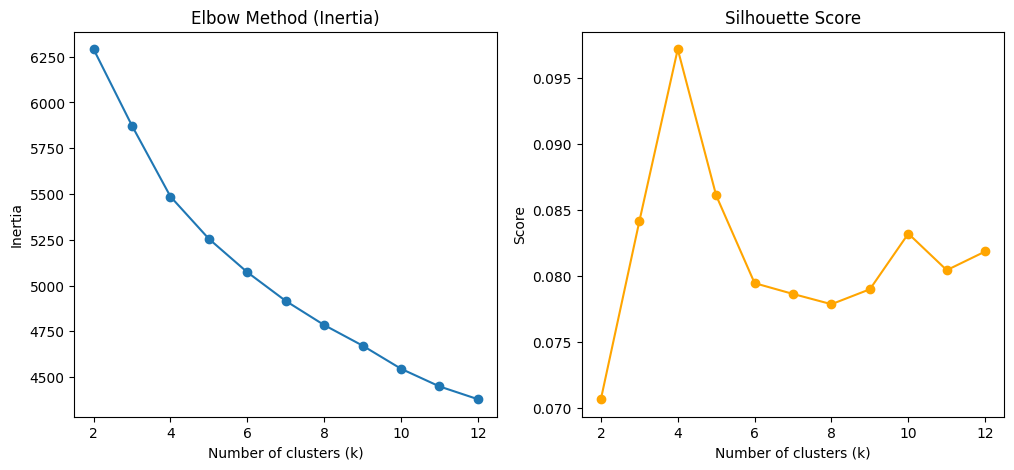

In [45]:
# Plot the results
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(results_df["k"], results_df["inertia"], marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(results_df["k"], results_df["silhouette"], marker='o', color='orange')
plt.title("Silhouette Score")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Score")
plt.savefig('Plots/Kmeans_Silhouette.png')
plt.show()

In [46]:
#Combine train + validation features for final training
X_trainval = np.vstack([X_train, X_val])

#Fit final k-means model
final_kmeans = KMeans(
    n_clusters=2, init="k-means++", n_init=50, max_iter=500, random_state=42
)
final_kmeans.fit(X_trainval)
# Assign clusters to each split
train_clusters = final_kmeans.predict(X_train)
val_clusters   = final_kmeans.predict(X_val)
test_clusters  = final_kmeans.predict(X_test)

C:\Users\ismai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\ismai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\ismai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [47]:
# Add cluster assignments to original dataframes
K_train=train_df.copy()
K_train['cluster'] = train_clusters
K_val=val_df.copy()
K_val['cluster'] = val_clusters
K_test=test_df.copy()
K_test['cluster'] = test_clusters

In [48]:
# Analyze default rates per cluster
def cluster_default_rates(df):
    return df.groupby("cluster")["default_flag"].agg(
        cluster_size="count",
        default_rate="mean"
    ).sort_values("default_rate", ascending=False)

train_cluster_stats = cluster_default_rates(K_train)
val_cluster_stats   = cluster_default_rates(K_val)
test_cluster_stats  = cluster_default_rates(K_test)

print("Train Cluster Default Rates:\n", train_cluster_stats)
print("\nValidation Cluster Default Rates:\n", val_cluster_stats)
print("\nTest Cluster Default Rates:\n", test_cluster_stats)


Train Cluster Default Rates:
          cluster_size  default_rate
cluster                            
1                 292      0.082192
0                 303      0.072607

Validation Cluster Default Rates:
          cluster_size  default_rate
cluster                            
1                  98      0.081633
0                 101      0.079208

Test Cluster Default Rates:
          cluster_size  default_rate
cluster                            
1                 110       0.10000
0                  89       0.05618


In [49]:
# Split features and target for clustered data
x_k_train=K_train.drop(columns=[target_col])
x_k_val=K_val.drop(columns=[target_col])
x_k_test=K_test.drop(columns=[target_col])
y_k_train=K_train[target_col]
y_k_val=K_val[target_col]
y_k_test=K_test[target_col]

K-Means and Random Forest Model

In [50]:
# Initialise Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,      # Let it grow until pure leaves or min_samples constraints
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(x_k_train, y_k_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [51]:
#Evaluate on validation set
# Predictions
rf_preds = rf_model.predict(x_k_val)
rf_probs = rf_model.predict_proba(x_k_val)[:, 1]

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_k_val, rf_preds))
print("ROC AUC Score:", roc_auc_score(y_k_val, rf_probs))
print("F1 Score:", f1_score(y_k_val, rf_preds))
print("Recall Score:", recall_score(y_k_val, rf_preds))
print("Precision Score:", precision_score(y_k_val, rf_preds))


Confusion Matrix:
 [[183   0]
 [  4  12]]
ROC AUC Score: 0.9996584699453552
F1 Score: 0.8571428571428571
Recall Score: 0.75
Precision Score: 1.0


In [52]:
#get the threshold for the best f1 score
precision, recall, thresholds = precision_recall_curve(y_k_val, rf_probs)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_f1_index = np.argmax(f1_scores)
best_f1_threshold = thresholds[best_f1_index]
print("Best F1 Score Threshold:", best_f1_threshold)

Best F1 Score Threshold: 0.2966666666666667


In [53]:
# Apply the best threshold to get final predictions
rf_k_probs = rf_model.predict_proba(x_k_test)[:, 1]
rf_k_preds = (rf_k_probs >= best_f1_threshold).astype(int)
print("Confusion Matrix on Test Set:\n", confusion_matrix(y_k_test, rf_k_preds))
print("Accuracy:", accuracy_score(y_k_test, rf_k_preds))
print("Recall:", recall_score(y_k_test, rf_k_preds))
print("Precision:", precision_score(y_k_test, rf_k_preds))
print("F1 Score:", f1_score(y_k_test, rf_k_preds))
print("ROC AUC Score:", roc_auc_score(y_k_test, rf_k_probs))


Confusion Matrix on Test Set:
 [[183   0]
 [  3  13]]
Accuracy: 0.9849246231155779
Recall: 0.8125
Precision: 1.0
F1 Score: 0.896551724137931
ROC AUC Score: 0.9904371584699454


In [54]:
# Save results to JSON
fpr, tpr, thresholds = roc_curve(y_k_test, rf_k_probs)
results = {
    "threshold": float(best_f1_threshold),
    "confusion_matrix": confusion_matrix(y_k_test, rf_k_preds).tolist(),
    "accuracy": accuracy_score(y_k_test, rf_k_preds),
    "precision": precision_score(y_k_test, rf_k_preds),
    "recall": recall_score(y_k_test, rf_k_preds),
    "f1_score": f1_score(y_k_test, rf_k_preds),
    "roc_auc": roc_auc_score(y_k_test, rf_k_probs),
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "roc_thresholds": thresholds.tolist(),    
}
with open("Results\K-Means_RF_model_results.json", "w") as f:
    json.dump(results, f)

In [55]:
#get the top features for both models
# Feature importance for Random Forest
importances = rf_model.feature_importances_
feature_names = x_k_train.columns
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importance_clean = feature_importance[feature_importance['Feature'] != 'cluster']
print("RF Feature Importance:\n", feature_importance_clean.head(6))
feature_importance_clean.head(6).to_csv("Results/kmeans_rf_feature_importance.csv", index=False)


RF Feature Importance:
                      Feature  Importance
0       bnpl_usage_frequency    0.163474
1            bnpl_debt_ratio    0.162226
2   stress_usage_interaction    0.134855
3     financial_stress_score    0.129335
4  payment_delinquency_count    0.117098
5   credit_limit_utilisation    0.094124


K-Means and XGboost Model

In [56]:
#Initialize and fit XGBoost model
XG_model = XGBClassifier(random_state=SEED,
                      use_label_encoder=False,
                      eval_metric="logloss")  

XG_model.fit(x_k_train, y_k_train)

# Predict & evaluate:
y_valid_proba = XG_model.predict_proba(x_k_val)[:, 1]
auc = roc_auc_score(y_val, y_valid_proba)
print(f"Validation ROC AUC: {auc:.4f}")


Validation ROC AUC: 1.0000


C:\Users\ismai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [14:41:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [57]:
# Hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

rs = RandomizedSearchCV(
    estimator=XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=SEED,
        n_jobs=1,               
    ),
    param_distributions=param_dist,
    n_iter=50,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1,                 
    random_state=SEED
)

with parallel_backend("threading"):    
    rs.fit(x_k_train, y_k_train)
best_params = rs.best_params_


Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\ismai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [14:42:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [58]:
# Re-instantiate with best params
best_model = XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=SEED
)

# Fit on train + valid 
best_model.fit(
    x_k_train,
    y_k_train,
    eval_set=[(x_k_val, y_k_val)],
    verbose=False
)

# Final AUC on the validation set:
xgb_valid_proba = best_model.predict_proba(x_k_val)[:, 1]
print("Tuned model ROC AUC on valid: ",
      roc_auc_score(y_k_val, xgb_valid_proba))


C:\Users\ismai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [14:42:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tuned model ROC AUC on valid:  1.0


In [59]:
# Find optimal threshold based on F1 score
thresholds = np.linspace(0.01, 0.99, 99)
scores = [f1_score(y_val, (xgb_valid_proba >= t).astype(int)) for t in thresholds]
xgb_best_t = thresholds[np.argmax(scores)]
print("Best threshold:", xgb_best_t)


Best threshold: 0.09999999999999999


In [61]:
# Evaluate on the test set
xgb_proba = best_model.predict_proba(x_k_test)[:, 1]
xgb_pred = (xgb_proba >= xgb_best_t).astype(int)
print("Confusion matrix:\n", confusion_matrix(y_k_test, xgb_pred))
print("Precision:", precision_score(y_k_test, xgb_pred))
print("Recall:", recall_score(y_k_test, xgb_pred))
print("F1-score:", f1_score(y_k_test, xgb_pred))
print("AUC:", roc_auc_score(y_k_test, xgb_proba))

Confusion matrix:
 [[183   0]
 [  1  15]]
Precision: 1.0
Recall: 0.9375
F1-score: 0.967741935483871
AUC: 1.0


In [62]:
fpr, tpr, thresholds = roc_curve(y_k_test, xgb_pred)
# Calculate metrics
results = {
    "threshold": thr,  # Default threshold, can be adjusted based on validation set
    "confusion_matrix": confusion_matrix(y_k_test, xgb_pred).tolist(),  # Convert to list for JSON compatibility
    "accuracy": accuracy_score(y_k_test, xgb_pred),
    "precision": precision_score(y_k_test, xgb_pred),
    "recall": recall_score(y_k_test, xgb_pred),
    "f1_score": f1_score(y_k_test, xgb_pred),
    "roc_auc": roc_auc_score(y_k_test, xgb_proba),
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "roc_thresholds": thresholds.tolist(),
}
# Save results to a JSON file
with open("Results\K-Means_XGB_model_results.json", "w") as json_file:
    json.dump(results, json_file, indent=4)


In [64]:
# Feature importance for XGBoost
importances = rf_model.feature_importances_
feature_names = x_k_train.columns
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)
display(feature_importance.head(15))
feature_importance_clean = feature_importance[feature_importance['Feature'] != 'cluster']
print("XGBoost Feature Importance:\n", feature_importance_clean.head(6))
feature_importance_clean.head(6).to_csv("Results/kmeans_xgb_feature_importance.csv", index=False)


,Feature,Importance
0,bnpl_usage_frequency,0.163474
1,bnpl_debt_ratio,0.162226
2,stress_usage_interaction,0.134855
3,financial_stress_score,0.129335
4,payment_delinquency_count,0.117098
5,credit_limit_utilisation,0.094124
6,debt_accumulation_metric,0.057045
7,financial_literacy_assessment,0.035225
8,impulsive_buying_score,0.033446
9,demographic_risk_factor,0.027763


XGBoost Feature Importance:
                      Feature  Importance
0       bnpl_usage_frequency    0.163474
1            bnpl_debt_ratio    0.162226
2   stress_usage_interaction    0.134855
3     financial_stress_score    0.129335
4  payment_delinquency_count    0.117098
5   credit_limit_utilisation    0.094124


XGBoost Feature Importance:
                      Feature  Importance
0       bnpl_usage_frequency    0.279583
1  payment_delinquency_count    0.254089
2     financial_stress_score    0.111894
3            bnpl_debt_ratio    0.109197
4   credit_limit_utilisation    0.074202
5   stress_usage_interaction    0.064793
